In [651]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
%matplotlib inline

In [652]:
import os
curr_directory = os.getcwd()
datafile = curr_directory + "/all_recipe_data.json"

In [653]:
import json
raw_recipe_data = pd.read_json(datafile)

## Preliminary data cleaning

In [654]:
raw_recipe_data.isnull().values.any()

False

In [655]:
raw_recipe_data = raw_recipe_data.replace(np.nan, "", regex=True)
raw_recipe_data.head()

,Author,Instructions
0,[witchywoman],"Mix grapefruit, orange, apples, pineapple, mar..."
1,[witchywoman],Fill a margarita glass with crushed ice. Pour ...
2,[witchywoman],Preheat an oven to 350 degrees F (175 degrees ...
3,[witchywoman],
4,[witchywoman],"Mix the teriyaki sauce, garlic, ginger, and re..."


In [656]:
raw_recipe_data.isnull().sum()

Author          0
Instructions    0
dtype: int64

In [657]:
raw_recipe_data.head()

,Author,Instructions
0,[witchywoman],"Mix grapefruit, orange, apples, pineapple, mar..."
1,[witchywoman],Fill a margarita glass with crushed ice. Pour ...
2,[witchywoman],Preheat an oven to 350 degrees F (175 degrees ...
3,[witchywoman],
4,[witchywoman],"Mix the teriyaki sauce, garlic, ginger, and re..."


In [658]:
raw_recipe_data.Author = raw_recipe_data.Author.apply(lambda x: x[0])

raw_recipe_data.Author.value_counts()

exception                    118
LoveMexiFood                  13
TheBritishBaker               13
witchywoman                   11
Johanna WISHES she were a     11
Litegal1                      10
Semigourmet                   10
Chef John                     10
Peach822                      10
ellie                         10
bellepepper                   10
Name: Author, dtype: int64

In [659]:
raw_recipe_data.drop(3, axis=0, inplace=True)
raw_recipe_data = raw_recipe_data[raw_recipe_data.Author != "exception"]
raw_recipe_data.reset_index(inplace=True)
raw_recipe_data.head(1)

,index,Author,Instructions
0,0,witchywoman,"Mix grapefruit, orange, apples, pineapple, mar..."


In [660]:
raw_recipe_data.drop(['index'], axis=1, inplace=True)
raw_recipe_data.head(1)

,Author,Instructions
0,witchywoman,"Mix grapefruit, orange, apples, pineapple, mar..."


In [661]:
from string import punctuation

transtab = str.maketrans({key:None for key in punctuation if key != "."})

In [662]:
# remove punctuation
raw_recipe_data.Instructions = raw_recipe_data.Instructions.apply(lambda x: x.lower().translate(transtab).strip().split("."))
raw_recipe_data.head()

,Author,Instructions
0,witchywoman,[mix grapefruit orange apples pineapple marasc...
1,witchywoman,"[fill a margarita glass with crushed ice, pou..."
2,witchywoman,[preheat an oven to 350 degrees f 175 degrees ...
3,witchywoman,[mix the teriyaki sauce garlic ginger and red ...
4,witchywoman,[fill a pint glass with ice and pour in the vo...


In [663]:
raw_recipe_data.Instructions.iloc[0]

['mix grapefruit orange apples pineapple maraschino cherries and grapes in a large bowl',
 ' mash slightly with the back of a wooden spoon to release juices',
 ' add bananas coconut walnuts and sugar stir to coat',
 ' cover and refrigerate to blend flavors at least 1 hour',
 '']

In [664]:
raw_recipe_data.loc[:,"FullInstruction"] = raw_recipe_data.Instructions.apply(lambda x: "".join(x))


In [665]:
# Get Instructions: List of list of sentences; DONE
# Flatten list of list of sentences -> List of sentences; DONE
# Remove stopwords from each sentence; DONE
# Create Train/Test split of sentences; DONE
# Pass Training set into Gensim; DONE

In [666]:
# get instructions
sentences = [text for text in raw_recipe_data.FullInstruction]
sentences[0]

'mix grapefruit orange apples pineapple maraschino cherries and grapes in a large bowl mash slightly with the back of a wooden spoon to release juices add bananas coconut walnuts and sugar stir to coat cover and refrigerate to blend flavors at least 1 hour'

In [667]:
# remove stop words
stoplist = set('a an and are as at be by for from has he in is it its of on or that the to was will with'.split(' '))
sentences_text = [[word for word in document.split() if word not in stoplist]
                  for document in sentences]

In [668]:
# flatten list of words of sentences
raw_recipe_data.dtypes

Author             object
Instructions       object
FullInstruction    object
dtype: object

In [669]:
raw_recipe_data['Author'] = raw_recipe_data['Author'].astype('category')
raw_recipe_data.dtypes

Author             category
Instructions         object
FullInstruction      object
dtype: object

In [670]:
raw_recipe_data['Author_codes'] = raw_recipe_data['Author'].cat.codes
raw_recipe_data.head()

,Author,Instructions,FullInstruction,Author_codes
0,witchywoman,[mix grapefruit orange apples pineapple marasc...,mix grapefruit orange apples pineapple marasch...,9
1,witchywoman,"[fill a margarita glass with crushed ice, pou...",fill a margarita glass with crushed ice pour t...,9
2,witchywoman,[preheat an oven to 350 degrees f 175 degrees ...,preheat an oven to 350 degrees f 175 degrees c...,9
3,witchywoman,[mix the teriyaki sauce garlic ginger and red ...,mix the teriyaki sauce garlic ginger and red p...,9
4,witchywoman,[fill a pint glass with ice and pour in the vo...,fill a pint glass with ice and pour in the vod...,9


In [671]:
raw_recipe_data['Author_codes'].value_counts()

6    13
3    13
1    11
9    10
8    10
7    10
5    10
4    10
2    10
0    10
Name: Author_codes, dtype: int64

### Reserve 25% of corpus for testing

In [672]:
len(sentences_text)

107

In [673]:
np.random.shuffle(sentences_text)
train, test = sentences_text[:81], sentences_text[81:]

## Create our gensim model

In [674]:
# import modules & set up logging
import gensim, logging

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [785]:
gensim.__version__

'3.4.0'

In [817]:
model = gensim.models.Word2Vec(train, min_count=3, sg=1, window=5, sample=1e-3)

2018-05-08 16:13:53,233 : INFO : collecting all words and their counts
2018-05-08 16:13:53,240 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-05-08 16:13:53,247 : INFO : collected 1051 word types from a corpus of 4611 raw words and 81 sentences
2018-05-08 16:13:53,250 : INFO : Loading a fresh vocabulary
2018-05-08 16:13:53,257 : INFO : min_count=3 retains 409 unique words (38% of original 1051, drops 642)
2018-05-08 16:13:53,258 : INFO : min_count=3 leaves 3803 word corpus (82% of original 4611, drops 808)
2018-05-08 16:13:53,263 : INFO : deleting the raw counts dictionary of 1051 items
2018-05-08 16:13:53,264 : INFO : sample=0.001 downsamples 106 most-common words
2018-05-08 16:13:53,266 : INFO : downsampling leaves estimated 2784 word corpus (73.2% of prior 3803)
2018-05-08 16:13:53,274 : INFO : estimated required memory for 409 words and 100 dimensions: 531700 bytes
2018-05-08 16:13:53,275 : INFO : resetting layer weights
2018-05-08 16:13:53,286 : IN

In [676]:
X = model[model.wv.vocab]

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [677]:
word_vectors = model.wv

### Vectorize our instructions.. for Science!

In [678]:
def avg_sentence_vector(words, model, num_features, index2word_set):
    #function to average all words vectors in a given paragraph
    featureVec = np.zeros((num_features,), dtype="float32")
    nwords = 0

    for word in words:
        if word not in index2word_set:
            if model.__contains__(word):
                nwords = nwords+1
                featureVec = np.add(featureVec, model[word])

    if nwords>0:
        featureVec = np.divide(featureVec, nwords)
    return featureVec

In [679]:
raw_recipe_data['Instruction_Vectors'] = raw_recipe_data.FullInstruction.apply(lambda x: avg_sentence_vector(x.split(),
                                                                                                             word_vectors,
                                                                                                             num_features = 100,
                                                                                                             index2word_set = stoplist))


In [680]:
# make dataframe from vectors so I don't have to use list() with my X later
vector_df = pd.DataFrame(data=list(raw_recipe_data.Instruction_Vectors))

In [681]:
vector_df['Author'] = raw_recipe_data['Author']

In [714]:
vector_df.shape

(107, 101)

In [716]:
FI_X = vector_df.loc[:, vector_df.columns != 'Author']
FI_y = vector_df['Author']

# Dimentionality Reduction

In [717]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(FI_X)

In [721]:
pca_data.shape

(107, 2)

IndexError: index 107 is out of bounds for axis 0 with size 107

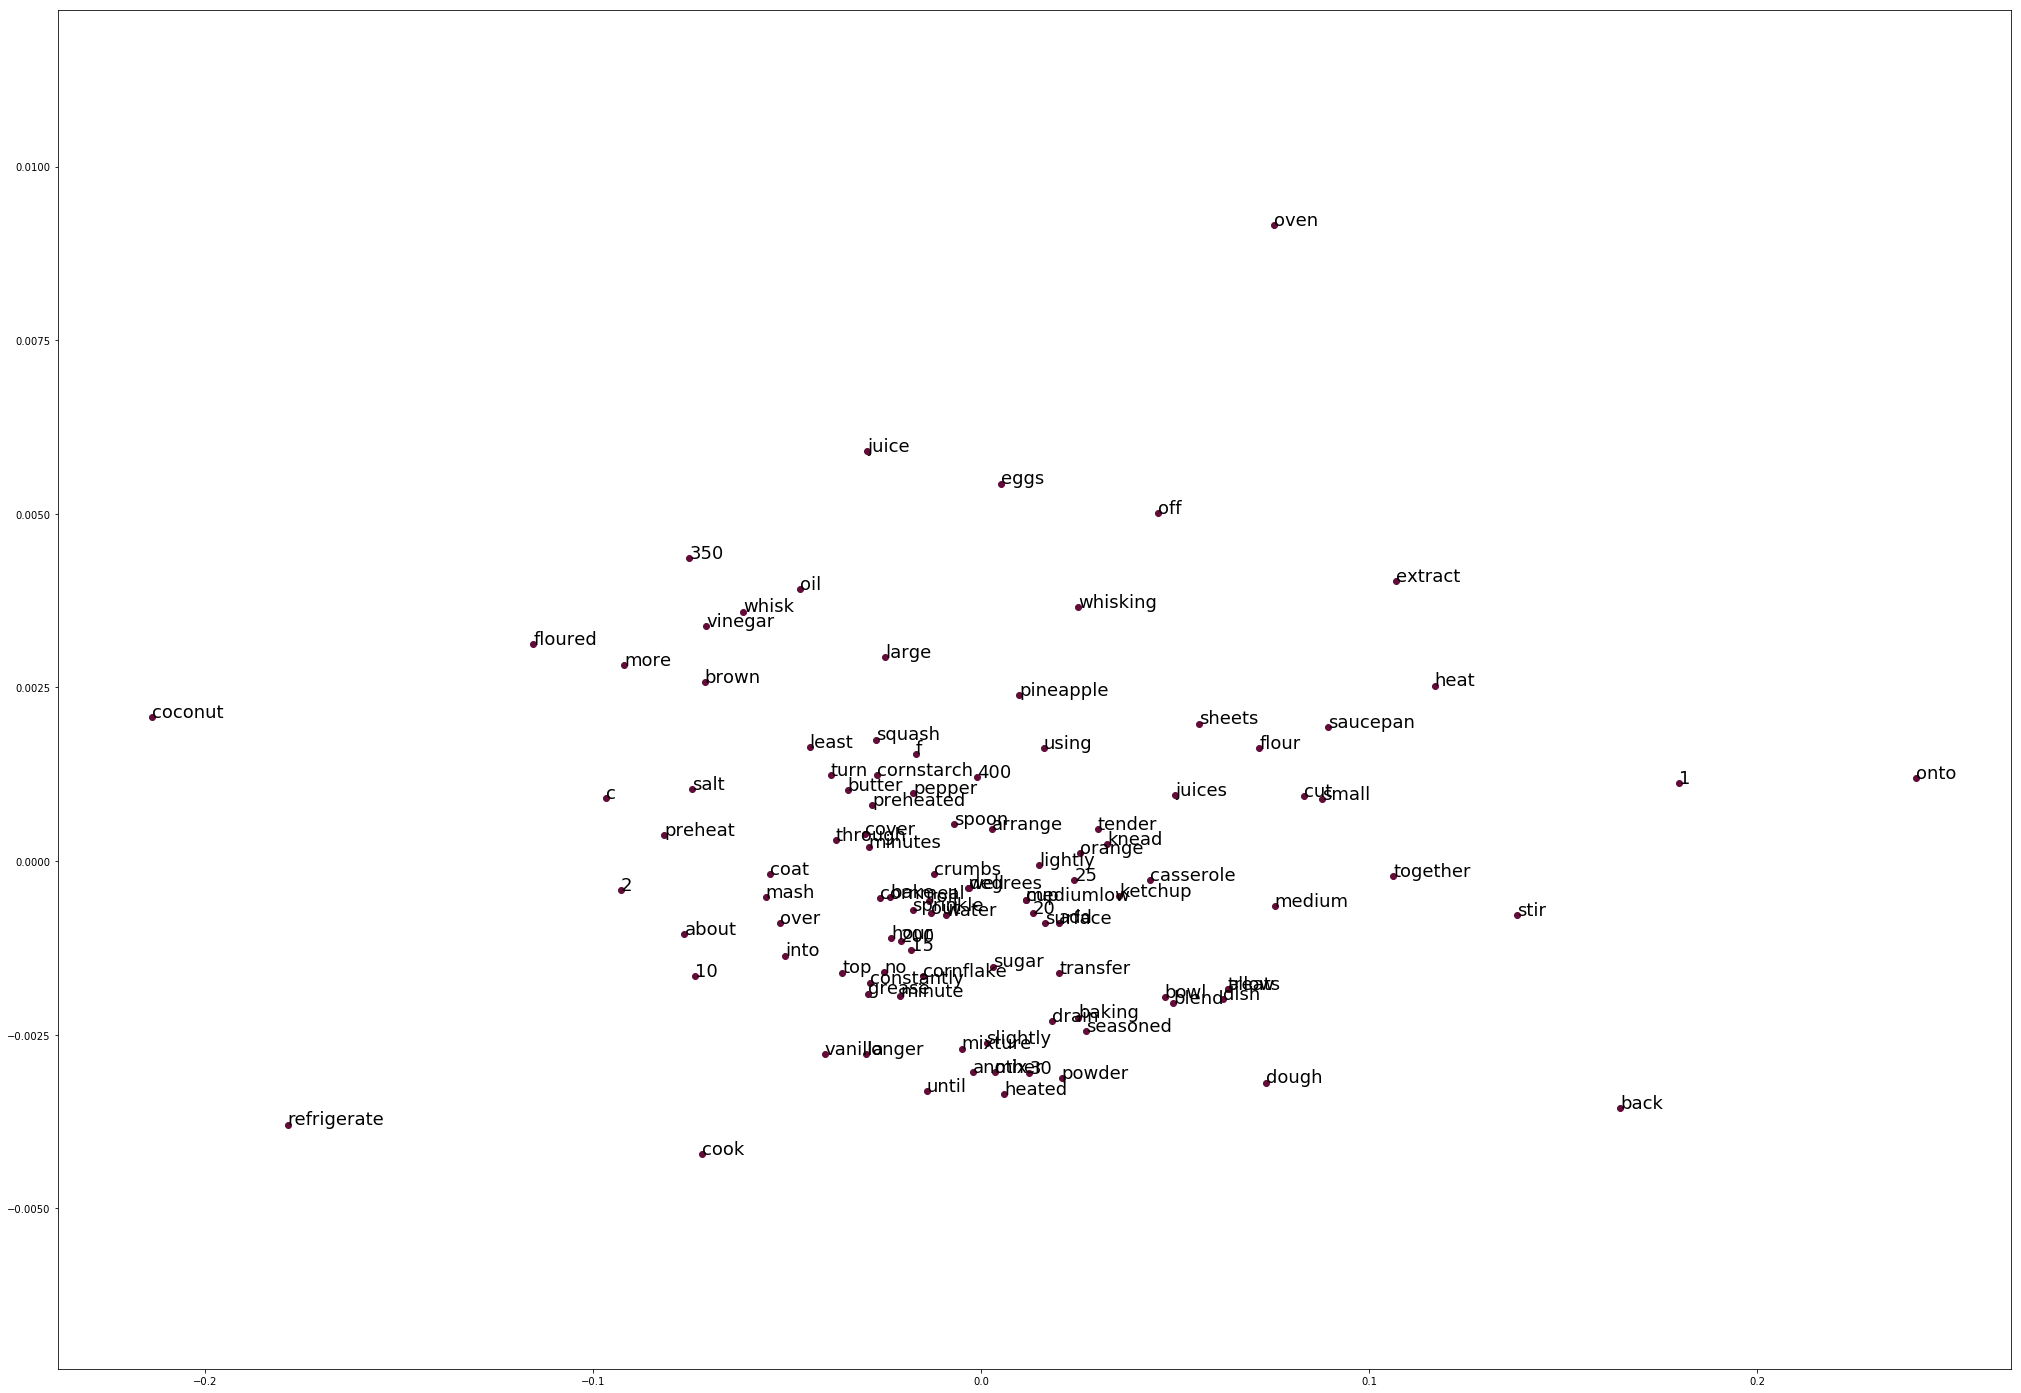

In [731]:
# PLOT PCA ONLY
plt.figure(figsize=((35,25)))
plt.scatter(pca_data[:, 0], pca_data[:, 1])
words = list(model.wv.vocab)
for i, word in enumerate(words):
	plt.annotate(word, xy=(pca_data[i, 0], pca_data[i, 1]), fontsize=18)


In [685]:
from sklearn import manifold

IndexError: index 107 is out of bounds for axis 0 with size 107

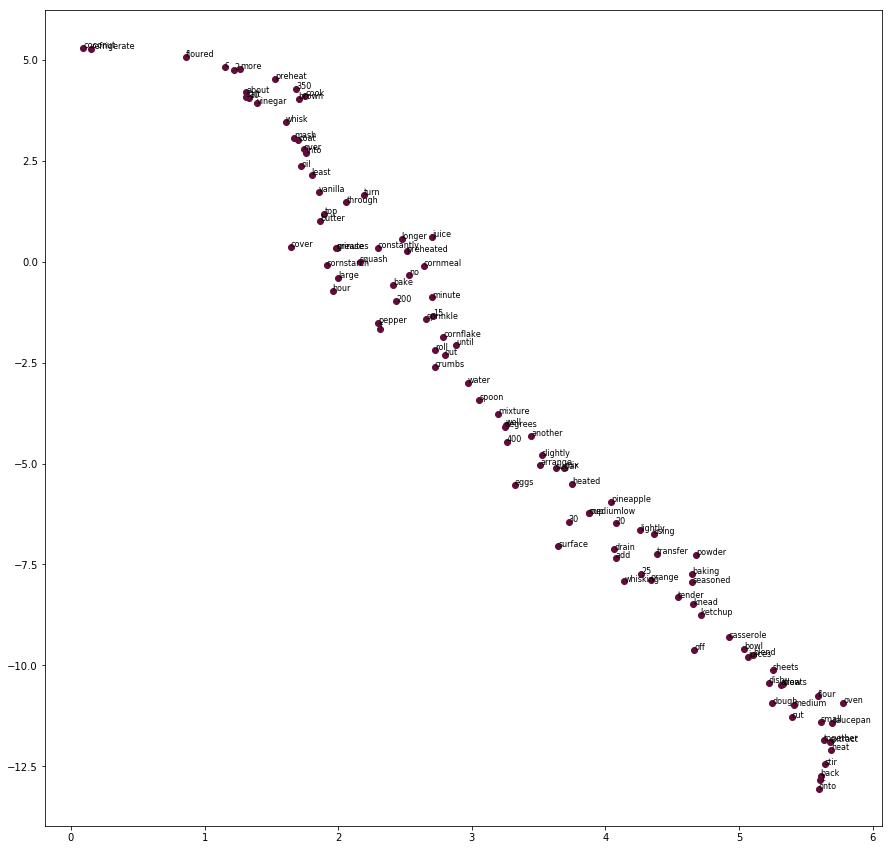

In [719]:
# PLOT TSNE ONLY
tsne = manifold.TSNE(n_components=2, init='pca', perplexity=30, random_state=0)
tsne_data = tsne.fit_transform(FI_X)
plt.figure(figsize=((15,15)))
plt.scatter(tsne_data[:, 0], tsne_data[:, 1])
words = list(model.wv.vocab)
for i, word in enumerate(words):
	plt.annotate(word, xy=(tsne_data[i, 0], tsne_data[i, 1]), fontsize=8)


/anaconda/lib/python3.6/site-packages/sklearn/manifold/mds.py:411: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


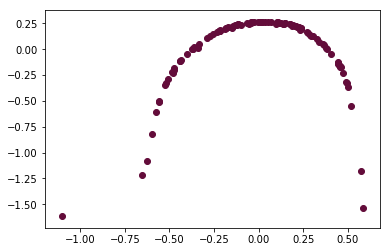

In [732]:
# PLOT MDS ONLY
from sklearn.metrics import euclidean_distances
from sklearn.neighbors import DistanceMetric
dist = DistanceMetric.get_metric('euclidean')

mds = manifold.MDS(2, max_iter=200, n_init=1)
distances = dist.pairwise(FI_X)
mds_data = mds.fit_transform(distances)
plt.scatter(mds_data[:, 0], mds_data[:, 1])

In [688]:
# PLOT TSVD ONLY
from sklearn.decomposition import TruncatedSVD
t_svd = TruncatedSVD(n_components=2)

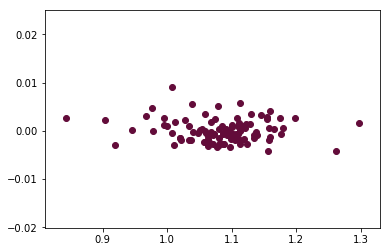

In [723]:
t_svd_data = t_svd.fit_transform(FI_X)
plt.scatter(t_svd_data[:, 0], t_svd_data[:, 1])

# Clustering

In [690]:
# set up clustering estimators
from sklearn import cluster

dbscan = cluster.DBSCAN(metric='cityblock', algorithm='auto', min_samples=3, eps=.2) 
meanshift = cluster.MeanShift()
spectral = cluster.SpectralClustering()
affinity = cluster.AffinityPropagation(damping=.6, preference=.5)

# DBSCAN 

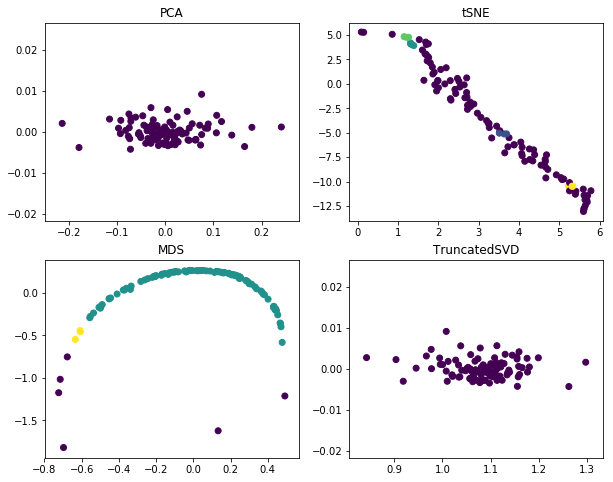

In [726]:
tsvd_dbscan_pred = dbscan.fit_predict(t_svd_data)
tsne_dbscan_pred = dbscan.fit_predict(tsne_data)
dbscan_pca_pred = dbscan.fit_predict(pca_data)
dbscan_mds_pred = dbscan.fit_predict(mds_data)
grid_size = (2,2)


plt.figure(figsize=(10,8))
plt.subplot2grid(grid_size, (0,0))
plt.scatter(pca_data[:, 0], pca_data[:,1], c = dbscan_pca_pred)
plt.title('PCA')

plt.subplot2grid(grid_size, (0,1))
plt.scatter(tsne_data[:, 0], tsne_data[:,1], c = tsne_dbscan_pred)
plt.title('tSNE')

plt.subplot2grid(grid_size, (1,1))
plt.scatter(t_svd_data[:, 0], t_svd_data[:,1], c = tsvd_dbscan_pred)
plt.title('TruncatedSVD')

plt.subplot2grid(grid_size, (1,0))
plt.scatter(mds_data[:, 0], mds_data[:,1], c = dbscan_mds_pred)
plt.title('MDS')

plt.show()

# MeanShift 

In [772]:
tsvd_meanshift = meanshift.fit(t_svd_data)
tsne_meanshift = meanshift.fit(tsne_data)
meanshift_pca = meanshift.fit(pca_data)
meanshift_mds = meanshift.fit(mds_data)

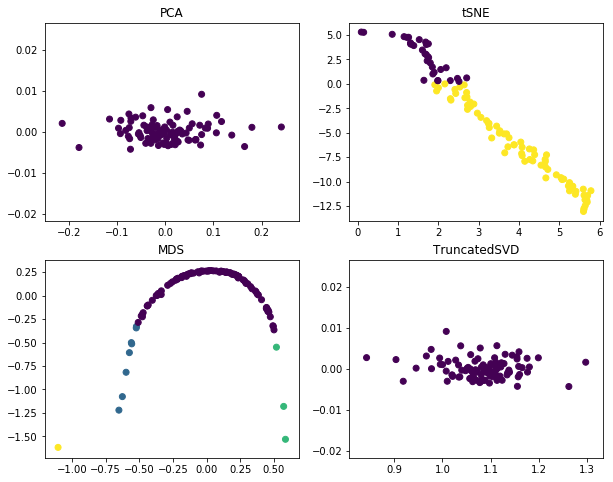

In [773]:
tsvd_meanshift_pred = meanshift.predict(t_svd_data)
tsne_meanshift_pred = meanshift.predict(tsne_data)
meanshift_pca_pred = meanshift.predict(pca_data)
meanshift_mds_pred = meanshift.predict(mds_data)
grid_size = (2,2)


plt.figure(figsize=(10,8))
plt.subplot2grid(grid_size, (0,0))
plt.scatter(pca_data[:, 0], pca_data[:,1], c = meanshift_pca_pred)
plt.title('PCA')

plt.subplot2grid(grid_size, (0,1))
plt.scatter(tsne_data[:, 0], tsne_data[:,1], c = tsne_meanshift_pred)
plt.title('tSNE')

plt.subplot2grid(grid_size, (1,1))
plt.scatter(t_svd_data[:, 0], t_svd_data[:,1], c = tsvd_meanshift_pred)
plt.title('TruncatedSVD')

plt.subplot2grid(grid_size, (1,0))
plt.scatter(mds_data[:, 0], mds_data[:,1], c = meanshift_mds_pred)
plt.title('MDS')

plt.show()

## Spectral Clustering 

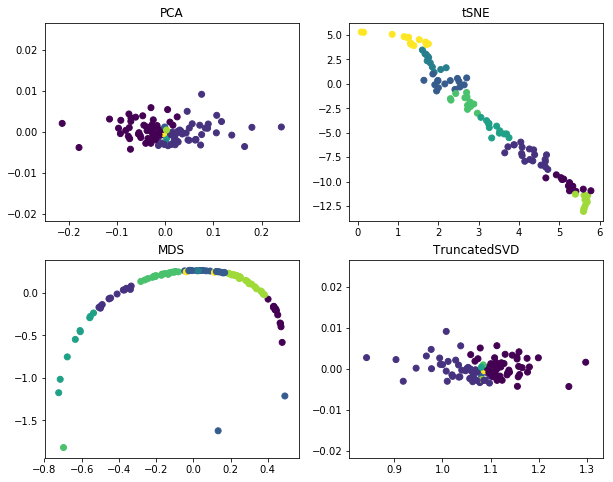

In [729]:
grid_size = (2,2)
tsvd_spectral_pred = spectral.fit_predict(t_svd_data)
tsne_spectral_pred = spectral.fit_predict(tsne_data)
spectral_pca_pred = spectral.fit_predict(pca_data)
spectral_mds_pred = spectral.fit_predict(mds_data)


plt.figure(figsize=(10,8))
plt.subplot2grid(grid_size, (0,0))
plt.scatter(pca_data[:, 0], pca_data[:,1], c = spectral_pca_pred)
plt.title('PCA')

plt.subplot2grid(grid_size, (0,1))
plt.scatter(tsne_data[:, 0], tsne_data[:,1], c = tsne_spectral_pred)
plt.title('tSNE')

plt.subplot2grid(grid_size, (1,1))
plt.scatter(t_svd_data[:, 0], t_svd_data[:,1], c = tsvd_spectral_pred)
plt.title('TruncatedSVD')

plt.subplot2grid(grid_size, (1,0))
plt.scatter(mds_data[:, 0], mds_data[:,1], c = spectral_mds_pred)
plt.title('MDS')

plt.show()

## Affinity Propogation

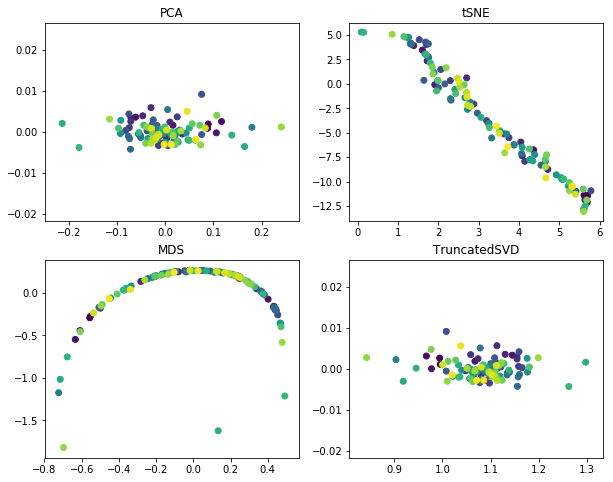

In [730]:
grid_size = (2,2)
tsvd_affinity_pred = affinity.fit_predict(t_svd_data)
tsne_affinity_pred = affinity.fit_predict(tsne_data)
affinity_pca_pred = affinity.fit_predict(pca_data)
affinity_mds_pred = affinity.fit_predict(mds_data)


plt.figure(figsize=(10,8))
plt.subplot2grid(grid_size, (0,0))
plt.scatter(pca_data[:, 0], pca_data[:,1], c = affinity_pca_pred)
plt.title('PCA')

plt.subplot2grid(grid_size, (0,1))
plt.scatter(tsne_data[:, 0], tsne_data[:,1], c = tsne_affinity_pred)
plt.title('tSNE')

plt.subplot2grid(grid_size, (1,1))
plt.scatter(t_svd_data[:, 0], t_svd_data[:,1], c = tsvd_affinity_pred)
plt.title('TruncatedSVD')

plt.subplot2grid(grid_size, (1,0))
plt.scatter(mds_data[:, 0], mds_data[:,1], c = affinity_mds_pred)
plt.title('MDS')

plt.show()

# Supervised Learning

In [733]:
#assign X,y, split training and testing

X_train, X_test, y_train, y_test = train_test_split(FI_X, FI_y, test_size=.25)

In [735]:
# reduce dimentionality
pca_X_train = pca.fit_transform(X_train)
tsne_X_train = tsne.fit_transform(X_train) 
t_svd_X_train = t_svd.fit_transform(X_train)

X_train_distances = dist.pairwise(X_train)
mds_X_train = mds.fit_transform(X_train_distances)

pca_X_test = pca.fit_transform(X_test)
tsne_X_test = tsne.fit_transform(X_test)
t_svd_X_test = t_svd.fit_transform(X_test)

X_test_distances = dist.pairwise(X_test)
mds_X_test = mds.fit_transform(X_test_distances)


/anaconda/lib/python3.6/site-packages/sklearn/manifold/mds.py:411: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


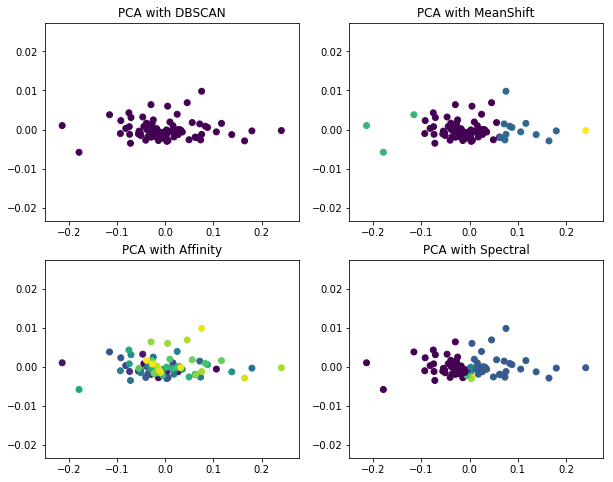

In [737]:
# try clustering on PCA_X_train with each estimator
X_dbscan_pred = dbscan.fit_predict(pca_X_train)
X_meanshift = meanshift.fit(pca_X_train)
X_meanshift_pred = meanshift.predict(pca_X_train)
X_spectral = spectral.fit_predict(pca_X_train)
X_affinity = affinity.fit_predict(pca_X_train)


grid_size = (2,2)


plt.figure(figsize=(10,8))
plt.subplot2grid(grid_size, (0,0))
plt.scatter(pca_X_train[:, 0], pca_X_train[:,1], c = X_dbscan_pred)
plt.title('PCA with DBSCAN')

plt.subplot2grid(grid_size, (0,1))
plt.scatter(pca_X_train[:, 0], pca_X_train[:,1], c = X_meanshift_pred)
plt.title('PCA with MeanShift')

plt.subplot2grid(grid_size, (1,1))
plt.scatter(pca_X_train[:, 0], pca_X_train[:,1], c = X_spectral)
plt.title('PCA with Spectral')

plt.subplot2grid(grid_size, (1,0))
plt.scatter(pca_X_train[:, 0], pca_X_train[:,1], c = X_affinity)
plt.title('PCA with Affinity')

plt.show()


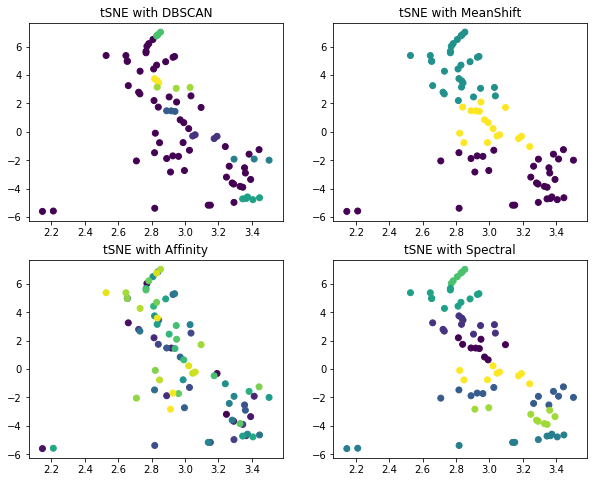

In [738]:
# tSNE data
X_dbscan_pred = dbscan.fit_predict(tsne_X_train)
X_meanshift = meanshift.fit(tsne_X_train)
X_meanshift_pred = meanshift.predict(tsne_X_train)
X_spectral = spectral.fit_predict(tsne_X_train)
X_affinity = affinity.fit_predict(tsne_X_train)


grid_size = (2,2)


plt.figure(figsize=(10,8))
plt.subplot2grid(grid_size, (0,0))
plt.scatter(tsne_X_train[:, 0], tsne_X_train[:,1], c = X_dbscan_pred)
plt.title('tSNE with DBSCAN')

plt.subplot2grid(grid_size, (0,1))
plt.scatter(tsne_X_train[:, 0], tsne_X_train[:,1], c = X_meanshift_pred)
plt.title('tSNE with MeanShift')

plt.subplot2grid(grid_size, (1,1))
plt.scatter(tsne_X_train[:, 0], tsne_X_train[:,1], c = X_spectral)
plt.title('tSNE with Spectral')

plt.subplot2grid(grid_size, (1,0))
plt.scatter(tsne_X_train[:, 0], tsne_X_train[:,1], c = X_affinity)
plt.title('tSNE with Affinity')

plt.show()


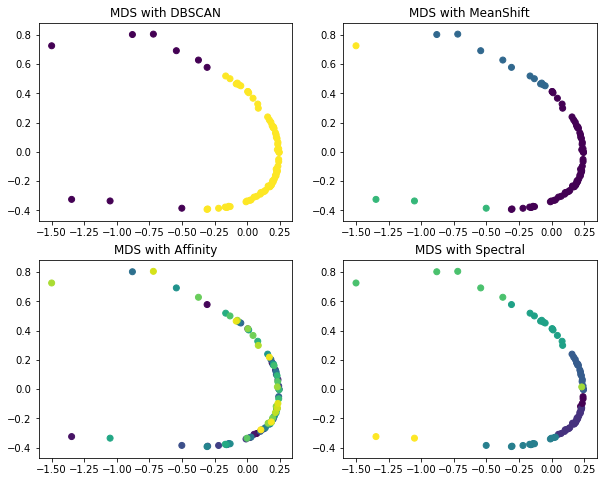

In [740]:
# MDS data
X_dbscan_pred = dbscan.fit_predict(mds_X_train)
X_meanshift = meanshift.fit(mds_X_train)
X_meanshift_pred = meanshift.predict(mds_X_train)
X_spectral = spectral.fit_predict(mds_X_train)
X_affinity = affinity.fit_predict(mds_X_train)


grid_size = (2,2)


plt.figure(figsize=(10,8))
plt.subplot2grid(grid_size, (0,0))
plt.scatter(mds_X_train[:, 0], mds_X_train[:,1], c = X_dbscan_pred)
plt.title('MDS with DBSCAN')

plt.subplot2grid(grid_size, (0,1))
plt.scatter(mds_X_train[:, 0], mds_X_train[:,1], c = X_meanshift_pred)
plt.title('MDS with MeanShift')

plt.subplot2grid(grid_size, (1,1))
plt.scatter(mds_X_train[:, 0], mds_X_train[:,1], c = X_spectral)
plt.title('MDS with Spectral')

plt.subplot2grid(grid_size, (1,0))
plt.scatter(mds_X_train[:, 0], mds_X_train[:,1], c = X_affinity)
plt.title('MDS with Affinity')

plt.show()


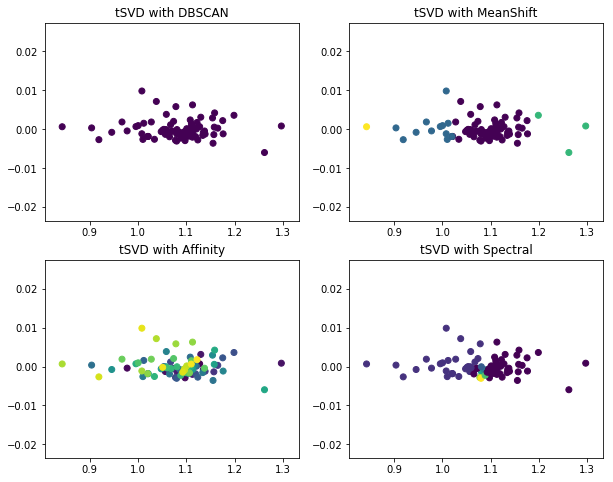

In [739]:
# t_svd data
X_dbscan_pred = dbscan.fit_predict(t_svd_X_train)
X_meanshift = meanshift.fit(t_svd_X_train)
X_meanshift_pred = meanshift.predict(t_svd_X_train)
X_spectral = spectral.fit_predict(t_svd_X_train)
X_affinity = affinity.fit_predict(t_svd_X_train)


grid_size = (2,2)


plt.figure(figsize=(10,8))
plt.subplot2grid(grid_size, (0,0))
plt.scatter(t_svd_X_train[:, 0], t_svd_X_train[:,1], c = X_dbscan_pred)
plt.title('tSVD with DBSCAN')

plt.subplot2grid(grid_size, (0,1))
plt.scatter(t_svd_X_train[:, 0], t_svd_X_train[:,1], c = X_meanshift_pred)
plt.title('tSVD with MeanShift')

plt.subplot2grid(grid_size, (1,1))
plt.scatter(t_svd_X_train[:, 0], t_svd_X_train[:,1], c = X_spectral)
plt.title('tSVD with Spectral')

plt.subplot2grid(grid_size, (1,0))
plt.scatter(t_svd_X_train[:, 0], t_svd_X_train[:,1], c = X_affinity)
plt.title('tSVD with Affinity')

plt.show()


In [701]:
from sklearn import ensemble
from sklearn.svm import SVC
from sklearn import tree
from sklearn import linear_model


In [702]:
from sklearn.model_selection import GridSearchCV

def check_grid(estimator, params, X, y):
    grid_classifier = GridSearchCV(estimator=estimator, param_grid=params)
    grid_classifier.fit(X, y)
    grid_score = grid_classifier.score(X, y)
    return (grid_classifier, grid_score)


In [703]:
# lets get some confusion matrices

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [704]:
# got my params
log_param = {'tol': (.01, .5, 1, 5),
             'C': (.01, .5, 1, 5),
             'solver': ('newton-cg', 'lbfgs', 'sag')}
forest_type_param = {'n_estimators': (100, 200, 300),
                       'criterion': ('gini', 'entropy'),
                       'max_depth': (2, 3, 5)}
gradient_param = {'learning_rate': (.01, .5, 1),
                   'n_estimators':(100, 200, 300),
                   'max_depth':(2, 3, 4, 5, 6)}
svc_param = {'C': (.1, .5, 1, 5),
             'kernel': ('linear', 'poly', 'rbf', 'sigmoid'),
             'degree': (2, 3, 4, 5),
             'gamma': (1, 2, 3)}

# got my estimators
logr = linear_model.LogisticRegression()
gradient = ensemble.GradientBoostingClassifier()
svc = SVC()
forest = ensemble.RandomForestClassifier()

estimators = [logr,
              gradient,
              svc,
              forest]
params = [log_param,
          gradient_param,
          svc_param,
          forest_type_param]

In [742]:
results = []

for estimator, param in list(zip(estimators, params)):
        best_estimator, grid_score = check_grid(estimator, param, X_train, y_train)
        y_pred = best_estimator.predict(X_test)
        accuracy = metrics.accuracy_score(y_test, y_pred)
        results.append((best_estimator, accuracy))
    
print(results)


[(GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'tol': (0.01, 0.5, 1, 5), 'C': (0.01, 0.5, 1, 5), 'solver': ('newton-cg', 'lbfgs', 'sag')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0), 0.1111111111111111), (GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_frac

In [747]:
best_estimator = ensemble.RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [750]:
best_estimator.fit(X_train, y_train)
print(best_estimator.score(X_train, y_train))
print(best_estimator.score(X_test, y_test))

0.975
0.25925925925925924


Confusion matrix, without normalization


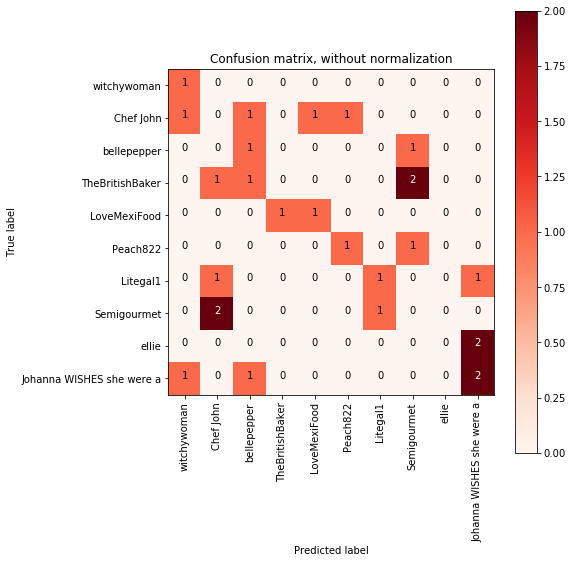

In [756]:
y_pred = best_estimator.predict(X_test)
c_matrix = metrics.confusion_matrix(y_test, y_pred)

class_names = FI_y.unique()

plt.figure(figsize=(8, 8))
plot_confusion_matrix(c_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

IndexError: index 75 is out of bounds for axis 1 with size 10

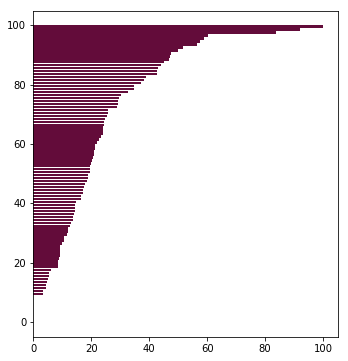

In [764]:
feature_importance = best_estimator.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, best_estimator.classes_[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

# Do it all over again with test data

In [821]:
# update model
model.train(test, total_examples=26, epochs=5)

2018-05-08 16:15:15,203 : INFO : training model with 3 workers on 409 vocabulary and 100 features, using sg=1 hs=0 sample=0.001 negative=5 window=5
2018-05-08 16:15:15,208 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-05-08 16:15:15,209 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-05-08 16:15:15,215 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-05-08 16:15:15,216 : INFO : EPOCH - 1 : training on 1746 raw words (1011 effective words) took 0.0s, 107422 effective words/s
2018-05-08 16:15:15,220 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-05-08 16:15:15,222 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-05-08 16:15:15,228 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-05-08 16:15:15,229 : INFO : EPOCH - 2 : training on 1746 raw words (1017 effective words) took 0.0s, 106065 effective words/s
2018-05-08 16:15:15,233 : INFO : worker thre

(5065, 8730)

In [824]:
# grab vocab
X2 = model[model.wv.vocab]

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app


In [833]:
updated_vectors = raw_recipe_data.FullInstruction.apply(lambda x: avg_sentence_vector(x.split(), 
                                                                                      word_vectors,
                                                                                      num_features = 100,
                                                                                      index2word_set = stoplist))


In [838]:
vector_df2 = pd.DataFrame(data=list(updated_vectors))

In [839]:
vector_df2['Author'] = raw_recipe_data['Author']

new_FI_X = vector_df2.loc[:, vector_df2.columns != 'Author']
new_FI_y = vector_df2['Author']

In [841]:
# reduce dimentionality for visualizing
pca = PCA(n_components=2)
pca_data2 = pca.fit_transform(new_FI_X)

tsne = manifold.TSNE(n_components=2, init='pca', perplexity=30, random_state=0)
tsne_data2 = tsne.fit_transform(new_FI_X)

mds = manifold.MDS(2, max_iter=200, n_init=1)
distances = dist.pairwise(new_FI_X)
mds_data2 = mds.fit_transform(distances)

t_svd = TruncatedSVD(n_components=2)
t_svd_data2 = t_svd.fit_transform(new_FI_X)

/anaconda/lib/python3.6/site-packages/sklearn/manifold/mds.py:411: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


# Clustering whole dataset with test data incorporated

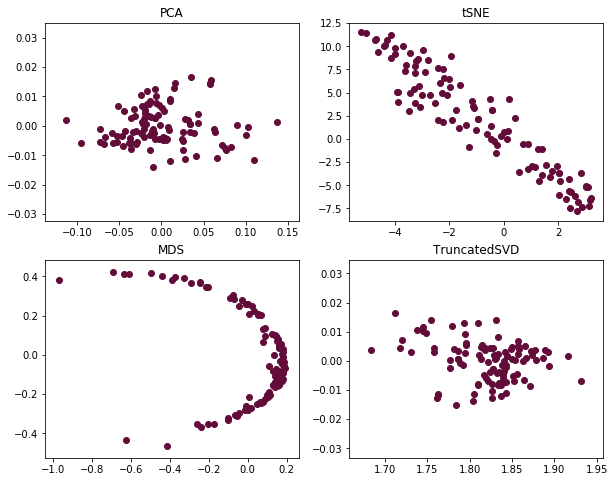

In [846]:
# cluster DBSCAN
tsvd_dbscan_pred = dbscan.fit_predict(t_svd_data2)
tsne_dbscan_pred = dbscan.fit_predict(tsne_data2)
dbscan_pca_pred = dbscan.fit_predict(pca_data2)
dbscan_mds_pred = dbscan.fit_predict(mds_data2)
grid_size = (2,2)


plt.figure(figsize=(10,8))
plt.subplot2grid(grid_size, (0,0))
plt.scatter(pca_data2[:, 0], pca_data2[:,1], cmap = dbscan_pca_pred)
plt.title('PCA')

plt.subplot2grid(grid_size, (0,1))
plt.scatter(tsne_data2[:, 0], tsne_data2[:,1], cmap = tsne_dbscan_pred)
plt.title('tSNE')

plt.subplot2grid(grid_size, (1,1))
plt.scatter(t_svd_data2[:, 0], t_svd_data2[:,1], cmap = tsvd_dbscan_pred)
plt.title('TruncatedSVD')

plt.subplot2grid(grid_size, (1,0))
plt.scatter(mds_data2[:, 0], mds_data2[:,1], cmap = dbscan_mds_pred)
plt.title('MDS')

plt.show()

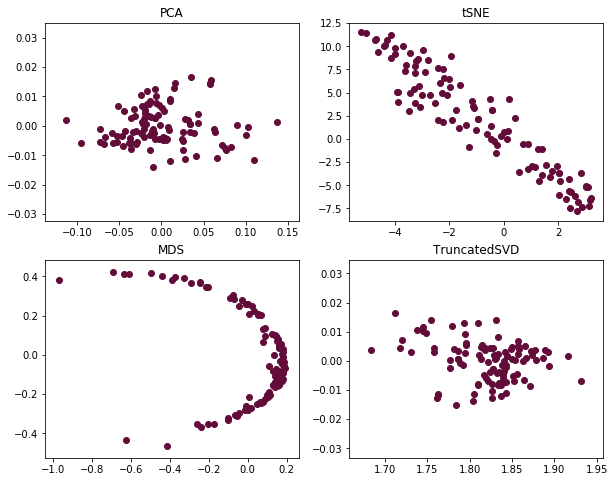

In [851]:
# Cluster Meanshift
tsvd_meanshift_pred = meanshift.fit_predict(t_svd_data2)
tsne_meanshift_pred = meanshift.fit_predict(tsne_data2)
meanshift_pca_pred = meanshift.fit_predict(pca_data2)
meanshift_mds_pred = meanshift.fit_predict(mds_data2)
grid_size = (2,2)


plt.figure(figsize=(10,8))
plt.subplot2grid(grid_size, (0,0))
plt.scatter(pca_data2[:, 0], pca_data2[:,1], cmap = meanshift_pca_pred)
plt.title('PCA')

plt.subplot2grid(grid_size, (0,1))
plt.scatter(tsne_data2[:, 0], tsne_data2[:,1], cmap = tsne_meanshift_pred)
plt.title('tSNE')

plt.subplot2grid(grid_size, (1,1))
plt.scatter(t_svd_data2[:, 0], t_svd_data2[:,1], cmap = tsvd_meanshift_pred)
plt.title('TruncatedSVD')

plt.subplot2grid(grid_size, (1,0))
plt.scatter(mds_data2[:, 0], mds_data2[:,1], cmap = meanshift_mds_pred)
plt.title('MDS')

plt.show()

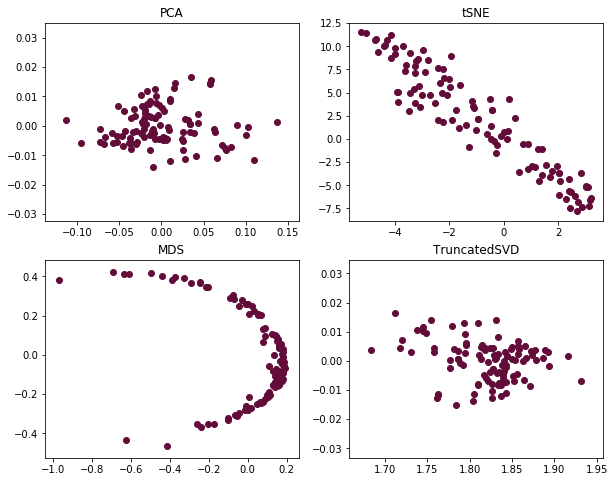

In [848]:
# plot affinity
grid_size = (2,2)
tsvd_affinity_pred = affinity.fit_predict(t_svd_data2)
tsne_affinity_pred = affinity.fit_predict(tsne_data2)
affinity_pca_pred = affinity.fit_predict(pca_data2)
affinity_mds_pred = affinity.fit_predict(mds_data2)


plt.figure(figsize=(10,8))
plt.subplot2grid(grid_size, (0,0))
plt.scatter(pca_data2[:, 0], pca_data2[:,1], cmap = affinity_pca_pred)
plt.title('PCA')

plt.subplot2grid(grid_size, (0,1))
plt.scatter(tsne_data2[:, 0], tsne_data2[:,1], cmap = tsne_affinity_pred)
plt.title('tSNE')

plt.subplot2grid(grid_size, (1,1))
plt.scatter(t_svd_data2[:, 0], t_svd_data2[:,1], cmap = tsvd_affinity_pred)
plt.title('TruncatedSVD')

plt.subplot2grid(grid_size, (1,0))
plt.scatter(mds_data2[:, 0], mds_data2[:,1], cmap = affinity_mds_pred)
plt.title('MDS')

plt.show()

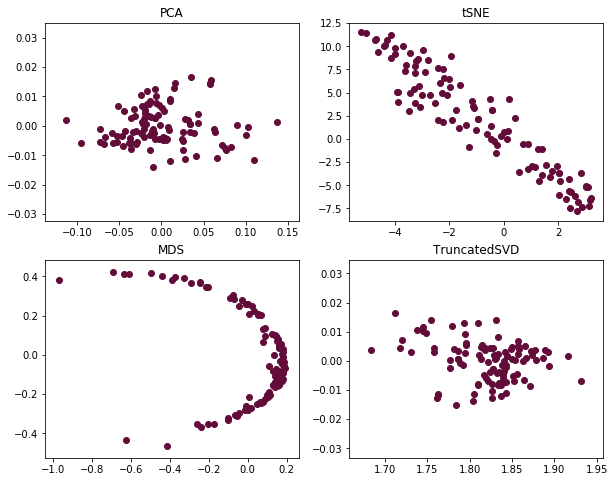

In [849]:
# cluster Spectral
grid_size = (2,2)
tsvd_spectral_pred = spectral.fit_predict(t_svd_data2)
tsne_spectral_pred = spectral.fit_predict(tsne_data2)
spectral_pca_pred = spectral.fit_predict(pca_data2)
spectral_mds_pred = spectral.fit_predict(mds_data2)


plt.figure(figsize=(10,8))
plt.subplot2grid(grid_size, (0,0))
plt.scatter(pca_data2[:, 0], pca_data2[:,1], cmap = spectral_pca_pred)
plt.title('PCA')

plt.subplot2grid(grid_size, (0,1))
plt.scatter(tsne_data2[:, 0], tsne_data2[:,1], cmap = tsne_spectral_pred)
plt.title('tSNE')

plt.subplot2grid(grid_size, (1,1))
plt.scatter(t_svd_data2[:, 0], t_svd_data2[:,1], cmap = tsvd_spectral_pred)
plt.title('TruncatedSVD')

plt.subplot2grid(grid_size, (1,0))
plt.scatter(mds_data2[:, 0], mds_data2[:,1], cmap = spectral_mds_pred)
plt.title('MDS')

plt.show()

these didn't cluster the same.. :/

In [853]:
# Supervised Learning
X_train2, X_test2, y_train2, y_test2 = train_test_split(new_FI_X, new_FI_y, test_size=.25)

In [855]:
# reduce dimentionality for plotting
pca_X_train2 = pca.fit_transform(X_train2)
tsne_X_train2 = tsne.fit_transform(X_train2) 
t_svd_X_train2 = t_svd.fit_transform(X_train2)

X_train_distances = dist.pairwise(X_train2)
mds_X_train2 = mds.fit_transform(X_train_distances)

pca_X_test2 = pca.fit_transform(X_test2)
tsne_X_test2 = tsne.fit_transform(X_test2)
t_svd_X_test2 = t_svd.fit_transform(X_test2)

X_test_distances2 = dist.pairwise(X_test2)
mds_X_test2 = mds.fit_transform(X_test_distances2)


/anaconda/lib/python3.6/site-packages/sklearn/manifold/mds.py:411: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


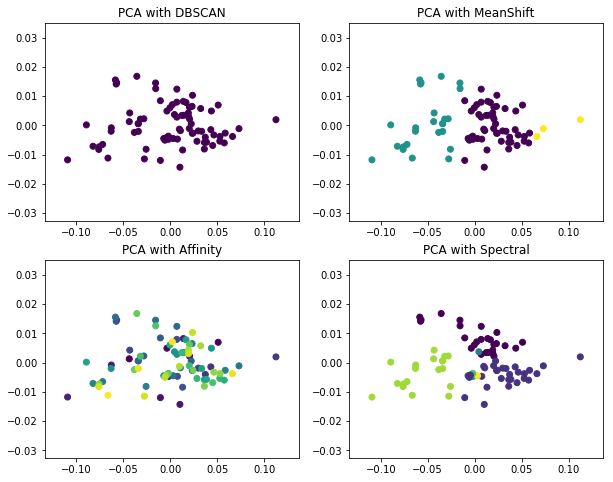

In [856]:
# try clustering on PCA_X_train with each estimator
X_dbscan_pred = dbscan.fit_predict(pca_X_train2)
X_meanshift = meanshift.fit(pca_X_train2)
X_meanshift_pred = meanshift.predict(pca_X_train2)
X_spectral = spectral.fit_predict(pca_X_train2)
X_affinity = affinity.fit_predict(pca_X_train2)


grid_size = (2,2)


plt.figure(figsize=(10,8))
plt.subplot2grid(grid_size, (0,0))
plt.scatter(pca_X_train2[:, 0], pca_X_train2[:,1], c = X_dbscan_pred)
plt.title('PCA with DBSCAN')

plt.subplot2grid(grid_size, (0,1))
plt.scatter(pca_X_train2[:, 0], pca_X_train2[:,1], c = X_meanshift_pred)
plt.title('PCA with MeanShift')

plt.subplot2grid(grid_size, (1,1))
plt.scatter(pca_X_train2[:, 0], pca_X_train2[:,1], c = X_spectral)
plt.title('PCA with Spectral')

plt.subplot2grid(grid_size, (1,0))
plt.scatter(pca_X_train2[:, 0], pca_X_train2[:,1], c = X_affinity)
plt.title('PCA with Affinity')

plt.show()


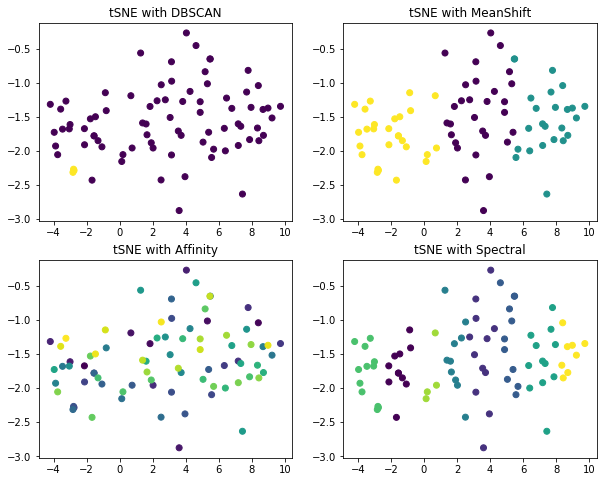

In [857]:
# tSNE data
X_dbscan_pred = dbscan.fit_predict(tsne_X_train2)
X_meanshift = meanshift.fit(tsne_X_train2)
X_meanshift_pred = meanshift.predict(tsne_X_train2)
X_spectral = spectral.fit_predict(tsne_X_train2)
X_affinity = affinity.fit_predict(tsne_X_train2)


grid_size = (2,2)


plt.figure(figsize=(10,8))
plt.subplot2grid(grid_size, (0,0))
plt.scatter(tsne_X_train2[:, 0], tsne_X_train2[:,1], c = X_dbscan_pred)
plt.title('tSNE with DBSCAN')

plt.subplot2grid(grid_size, (0,1))
plt.scatter(tsne_X_train2[:, 0], tsne_X_train2[:,1], c = X_meanshift_pred)
plt.title('tSNE with MeanShift')

plt.subplot2grid(grid_size, (1,1))
plt.scatter(tsne_X_train2[:, 0], tsne_X_train2[:,1], c = X_spectral)
plt.title('tSNE with Spectral')

plt.subplot2grid(grid_size, (1,0))
plt.scatter(tsne_X_train2[:, 0], tsne_X_train2[:,1], c = X_affinity)
plt.title('tSNE with Affinity')

plt.show()


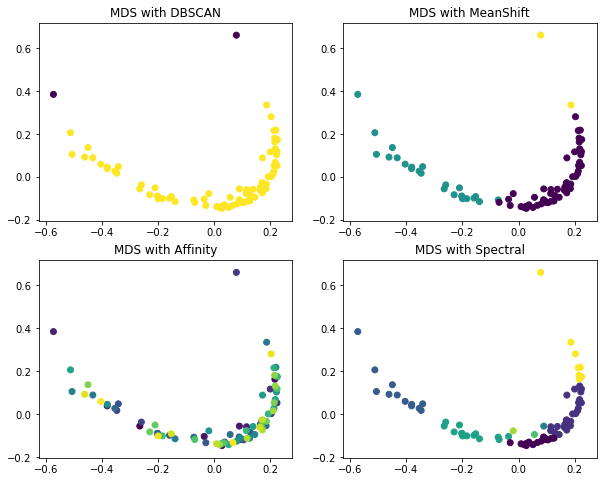

In [858]:
# MDS data
X_dbscan_pred = dbscan.fit_predict(mds_X_train2)
X_meanshift = meanshift.fit(mds_X_train2)
X_meanshift_pred = meanshift.predict(mds_X_train2)
X_spectral = spectral.fit_predict(mds_X_train2)
X_affinity = affinity.fit_predict(mds_X_train2)


grid_size = (2,2)


plt.figure(figsize=(10,8))
plt.subplot2grid(grid_size, (0,0))
plt.scatter(mds_X_train2[:, 0], mds_X_train2[:,1], c = X_dbscan_pred)
plt.title('MDS with DBSCAN')

plt.subplot2grid(grid_size, (0,1))
plt.scatter(mds_X_train2[:, 0], mds_X_train2[:,1], c = X_meanshift_pred)
plt.title('MDS with MeanShift')

plt.subplot2grid(grid_size, (1,1))
plt.scatter(mds_X_train2[:, 0], mds_X_train2[:,1], c = X_spectral)
plt.title('MDS with Spectral')

plt.subplot2grid(grid_size, (1,0))
plt.scatter(mds_X_train2[:, 0], mds_X_train2[:,1], c = X_affinity)
plt.title('MDS with Affinity')

plt.show()


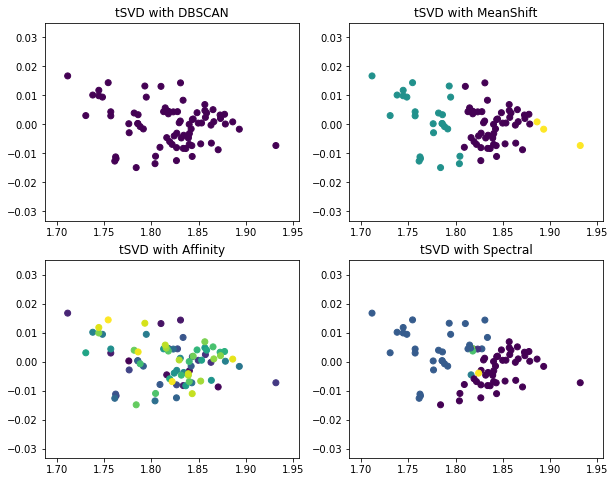

In [859]:
# t_svd data
X_dbscan_pred = dbscan.fit_predict(t_svd_X_train2)
X_meanshift = meanshift.fit(t_svd_X_train2)
X_meanshift_pred = meanshift.predict(t_svd_X_train2)
X_spectral = spectral.fit_predict(t_svd_X_train2)
X_affinity = affinity.fit_predict(t_svd_X_train2)


grid_size = (2,2)


plt.figure(figsize=(10,8))
plt.subplot2grid(grid_size, (0,0))
plt.scatter(t_svd_X_train2[:, 0], t_svd_X_train2[:,1], c = X_dbscan_pred)
plt.title('tSVD with DBSCAN')

plt.subplot2grid(grid_size, (0,1))
plt.scatter(t_svd_X_train2[:, 0], t_svd_X_train2[:,1], c = X_meanshift_pred)
plt.title('tSVD with MeanShift')

plt.subplot2grid(grid_size, (1,1))
plt.scatter(t_svd_X_train2[:, 0], t_svd_X_train2[:,1], c = X_spectral)
plt.title('tSVD with Spectral')

plt.subplot2grid(grid_size, (1,0))
plt.scatter(t_svd_X_train2[:, 0], t_svd_X_train2[:,1], c = X_affinity)
plt.title('tSVD with Affinity')

plt.show()


In [854]:
best_estimator.fit(X_train2, y_train2)
print(best_estimator.score(X_train2, y_train2))
print(best_estimator.score(X_test2, y_test2))

1.0
0.2222222222222222


Confusion matrix, without normalization


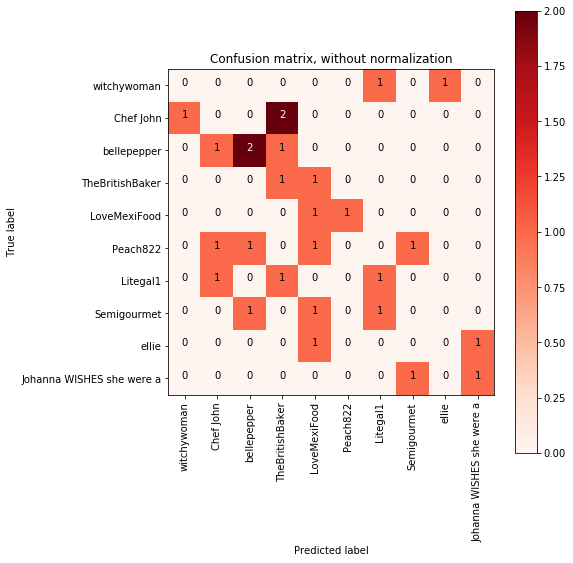

In [860]:
# confusion matrix for test set
y_pred2 = best_estimator.predict(X_test2)
c_matrix2 = metrics.confusion_matrix(y_test2, y_pred2)

class_names = new_FI_y.unique()

plt.figure(figsize=(8, 8))
plot_confusion_matrix(c_matrix2, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()